Diana Covaci, 261 086 280

Nicholas Milin, 261 106 314

Viktor Allais, 261 148 866

In [1]:
!pip install -q numpy pandas matplotlib seaborn scikit-learn ucimlrepo
!pip install -q torchvision

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import itertools
from IPython.core.debugger import set_trace
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from itertools import combinations
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

# Save and load model

In [ ]:
# Utility functions for saving and loading models
import os
import pickle

def save_model(model, filename, directory='saved_models'):
    """Save a model to disk
    Args:
        model: The model to save
        filename: Name of the file (will add .pkl if not present)
        directory: Directory to save in (will be created if it doesn't exist)
    """
    if not filename.endswith('.pkl'):
        filename += '.pkl'
    
    # Create directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    filepath = os.path.join(directory, filename)
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {filepath}")
    
def load_model(filename, directory='saved_models'):
    """Load a model from disk
    Args:
        filename: Name of the file (will add .pkl if not present)
        directory: Directory to load from
    Returns:
        The loaded model
    """
    if not filename.endswith('.pkl'):
        filename += '.pkl'
        
    filepath = os.path.join(directory, filename)
    with open(filepath, 'rb') as f:
        model = pickle.load(f)
    print(f"Model loaded from {filepath}")
    return model

# Task 1: Acquire the data

In [9]:
# find mean & std for train_dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

loader_iter = iter(loader)
images, _ = next(loader_iter)
mean_train = images.mean().item()
std_train = images.std().item()
print((mean_train, std_train))

# normalize train_dataset & test_dataset
mlp_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
    transforms.Lambda(lambda x:x.view(-1))
])

full_train_dataset_normalized = datasets.FashionMNIST(root='./data', train=True, download=True, transform=mlp_transform)
test_dataset_normalized = datasets.FashionMNIST(root='./data', train=False, download=True, transform=mlp_transform)

# split full train set into train and validation sets (80/20)
train_size = int(0.8*len(full_train_dataset_normalized))
val_size = len(full_train_dataset_normalized) - train_size

# Add generator seed for reproducibility
generator = torch.Generator().manual_seed(42)
train_dataset_normalized, val_dataset_normalized = random_split(full_train_dataset_normalized, [train_size, val_size], generator=generator)

# create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset_normalized, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(val_dataset_normalized, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset_normalized, batch_size=batch_size, shuffle=False)

# sanity check
x, y = next(iter(train_loader))
print((x.shape, y.shape)) # expect [64, 784] and [64]
input_size = x.shape[1]
output_size = len(set(full_train_dataset_normalized.targets.numpy()))
print(input_size, output_size)

(0.28604060411453247, 0.3530242443084717)
(torch.Size([64, 784]), torch.Size([64]))
784 10


# Task 2: Implement a Multilayer Perceptron

## Accuracy Score

In [12]:
def evaluate_acc(true, pred):
  return np.sum(true == pred) / len(true)

## Activation Functions

In [13]:
class relu:
  def activation(self, x):
    return np.maximum(0, x)
  def derivative(self, x):
    return np.where(x > 0, 1, 0)

class leakyRelu:
  def __init__(self, gamma=0.01):
    self.gamma = gamma
  def activation(self, x):
    return np.where(x > 0, x, self.gamma * x)
  def derivative(self, x):
    return np.where(x > 0, 1, self.gamma)

class sigmoid:
  def activation(self, x):
    return 1 / (1 + np.exp(-x))
  def derivative(self, x):
    return self.activation(x) * (1 - self.activation(x))

class tanh:
  def activation(self, x):
    return np.tanh(x)
  def derivative(self, x):
    return 1 - np.tanh(x) ** 2

class softmax:
  def activation(self, x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    total = np.sum(exp_x, axis=1, keepdims=True)
    return exp_x / total
  def derivative(self, x):
    return self.activation(x) * (1 - self.activation(x))


## MLP

In [14]:
def softmax(X):
  exp_X = np.exp(X - np.max(X, axis=1, keepdims=True))
  return exp_X / np.sum(exp_X, axis=1, keepdims=True)

# implementing the MLP class
class MLP:

  def __init__(self, activation_function, num_hidden_layers, units):
    self.activation_function = activation_function
    self.num_hidden_layers = num_hidden_layers
    self.units = units

    # initialize weights and biases
    layer_sizes = [input_size] + units + [output_size]
    self.L = num_hidden_layers + 1  # Number of layers (excluding input) (input is 0 indexed)
    self.weights = []
    self.biases = []
    self.activations = {}
    self.z_values = {}
    self.loss_history = []
    self.accuracy_history = []
    self.test_accuracy_history = []

    for i in range(len(layer_sizes)-1):
      w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2/layer_sizes[i])
      b = np.zeros((1, layer_sizes[i+1]))
      self.weights.append(w)
      self.biases.append(b)

    self.grad_weights = {}
    self.grad_biases = {}


  def forward_propagation(self, X):
    # Forward propagation through the network
    self.activations[0] = X
    previous_activation = X
    # Hidden layers
    for l in range(self.L):
        W = self.weights[l]
        b = self.biases[l]

        Z = np.dot(previous_activation, W) + b
        # Activation for Layer L (last layer)
        if l == self.L - 1:
          A = softmax(Z)
        else:
          A = self.activation_function.activation(Z)

        self.z_values[l+1] = Z
        self.activations[l+1] = A
        previous_activation = A

    # Sums to 1 as it is softmax
    return previous_activation

  def backward_propagation(self, AL, X, Y):
    m = Y.shape[0]
    num_layers = self.L
    dZ = AL - Y

    for l in reversed(range(num_layers)):
      if l == 0:
        previous_activation = X
      else:
        previous_activation = self.activations[l]
      W = self.weights[l]

      self.grad_weights[l] = np.dot(previous_activation.T, dZ) / m
      self.grad_biases[l] = np.sum(dZ, axis=0, keepdims=True) / m

      if l > 0:
        # Compute gradient for previous layer
        dA_prev = np.dot(dZ, W.T)
        Z_prev = self.z_values[l]
        dZ = dA_prev * self.activation_function.derivative(Z_prev)


  def update_parameters(self):
    for l in range(self.L):
      self.weights[l] -= self.learning_rate * self.grad_weights[l]
      self.biases[l] -= self.learning_rate * self.grad_biases[l]


  def compute_loss(self, AL, Y):
    """Compute cross-entropy loss"""
    m = Y.shape[0]

    # Clip probabilities to avoid log(0)
    epsilon = 1e-15
    AL = np.clip(AL, epsilon, 1 - epsilon)

    # Cross-entropy loss
    cross_entropy = -np.sum(Y * np.log(AL)) / m

    return cross_entropy

  def compute_accuracy(self, true, pred):
    predictions = np.argmax(pred, axis=1)
    labels = np.argmax(true, axis=1)
    accuracy = np.mean(predictions == labels)
    return accuracy


  def fit(self, train_loader, test_loader, learning_rate, epochs):
    self.learning_rate = learning_rate
    for epoch in range(epochs):
      epoch_loss = 0
      n_batches = 0
      epoch_accuracy = 0

      for X_batch, y_batch in train_loader:
        X_batch_np = X_batch.numpy()
        y_batch_onehot = np.eye(output_size)[y_batch.numpy()] # One-hot encode labels

        # Forward propagation
        AL = self.forward_propagation(X_batch_np)

        # Compute loss and accuracy
        loss = self.compute_loss(AL, y_batch_onehot)
        accuracy = self.compute_accuracy(y_batch_onehot, AL)
        epoch_loss += loss
        epoch_accuracy += accuracy
        n_batches += 1

        # Backward propagation
        self.backward_propagation(AL, X_batch_np, y_batch_onehot)

        # Update parameters
        self.update_parameters()

      avg_loss = epoch_loss / n_batches
      avg_accuracy = epoch_accuracy / n_batches
      self.loss_history.append(avg_loss)
      self.accuracy_history.append(avg_accuracy)

      # Calculate test accuracy
      all_y_true_test = []
      all_y_pred_test = []
      for X_batch_test, y_batch_test in test_loader:
          X_batch_test_np = X_batch_test.numpy()
          y_batch_test_np = y_batch_test.numpy()
          y_pred_test = self.predict(X_batch_test_np)
          all_y_true_test.extend(y_batch_test_np)
          all_y_pred_test.extend(y_pred_test)
      test_accuracy = evaluate_acc(np.array(all_y_true_test), np.array(all_y_pred_test))
      self.test_accuracy_history.append(test_accuracy)


      print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

  '''
  def fit(self, X, y, learning_rate, epochs):
    self.learning_rate = learning_rate
    for epoch in range(epochs):
      # Random permutation of indices
      np.random.seed(42+epoch)
      indices = np.random.permutation(N)
      X_shuffled = X[indices]
      y_shuffled = y[indices]

      epoch_loss = 0
      n_batches = 0
      epoch_accuracy = 0

      # Mini-batch gradient descent
      for i in range(0, n_samples, batch_size):
        # Get mini-batch
        end_idx = min(i + batch_size, n_samples)
        X_batch = X_shuffled[i:end_idx]
        y_batch = y_shuffled[i:end_idx]

        # Forward propagation
        AL = self.forward_propagation(X_batch)

        # Compute loss
        loss = self.compute_loss(AL, y_batch)
        accuracy = self.compute_accuracy(y_batch, AL)
        epoch_loss += loss
        epoch_accuracy += accuracy
        n_batches += 1

        # Backward propagation
        self.backward_propagation(AL, X_batch, y_batch)

        # Update parameters
        self.update_parameters()
    return self
'''
  def predict(self, X):
    """Make predictions"""
    AL = self.forward_propagation(X)
    predictions = np.argmax(AL, axis=1)
    return predictions

  def plot_history(self):
    """Plots the training loss and accuracy history."""
    epochs = range(1, len(self.loss_history) + 1)

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, self.loss_history, 'bo-', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, self.accuracy_history, 'ro-', label='Training Accuracy')
    plt.plot(epochs, self.test_accuracy_history, 'go-', label='Test Accuracy')
    plt.title('Training and Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Task 3: Run the experiments and report

In [59]:
# Example of how to save and load models

# Save a model (e.g., after training)
save_model(model3, 'model3_backup')  # Will save to saved_models/model3_backup.pkl

# Load a model (creates a completely independent copy)
model3_copy = load_model('model3_backup')  # Will load from saved_models/model3_backup.pkl
# model3_copy.fit(....)

Model saved to saved_models/model3_backup.pkl
Model loaded from saved_models/model3_backup.pkl


## 3.1: Three different models

### Model 1: No hidden layers

In [15]:
model1 = MLP(activation_function=relu(), num_hidden_layers=0, units=[])
model1.fit(train_loader, test_loader, 0.01, 20)

Epoch 1/20, Loss: 0.6686, Train Accuracy: 0.7661, Test Accuracy: 0.7987
Epoch 2/20, Loss: 0.5037, Train Accuracy: 0.8231, Test Accuracy: 0.8172
Epoch 3/20, Loss: 0.4712, Train Accuracy: 0.8347, Test Accuracy: 0.8264
Epoch 4/20, Loss: 0.4544, Train Accuracy: 0.8415, Test Accuracy: 0.8322
Epoch 5/20, Loss: 0.4437, Train Accuracy: 0.8452, Test Accuracy: 0.8303
Epoch 6/20, Loss: 0.4354, Train Accuracy: 0.8480, Test Accuracy: 0.8347
Epoch 7/20, Loss: 0.4285, Train Accuracy: 0.8515, Test Accuracy: 0.8358
Epoch 8/20, Loss: 0.4235, Train Accuracy: 0.8525, Test Accuracy: 0.8364
Epoch 9/20, Loss: 0.4200, Train Accuracy: 0.8553, Test Accuracy: 0.8379
Epoch 10/20, Loss: 0.4157, Train Accuracy: 0.8560, Test Accuracy: 0.8353
Epoch 11/20, Loss: 0.4124, Train Accuracy: 0.8570, Test Accuracy: 0.8359
Epoch 12/20, Loss: 0.4098, Train Accuracy: 0.8582, Test Accuracy: 0.8306
Epoch 13/20, Loss: 0.4075, Train Accuracy: 0.8588, Test Accuracy: 0.8416
Epoch 14/20, Loss: 0.4046, Train Accuracy: 0.8595, Test Accu

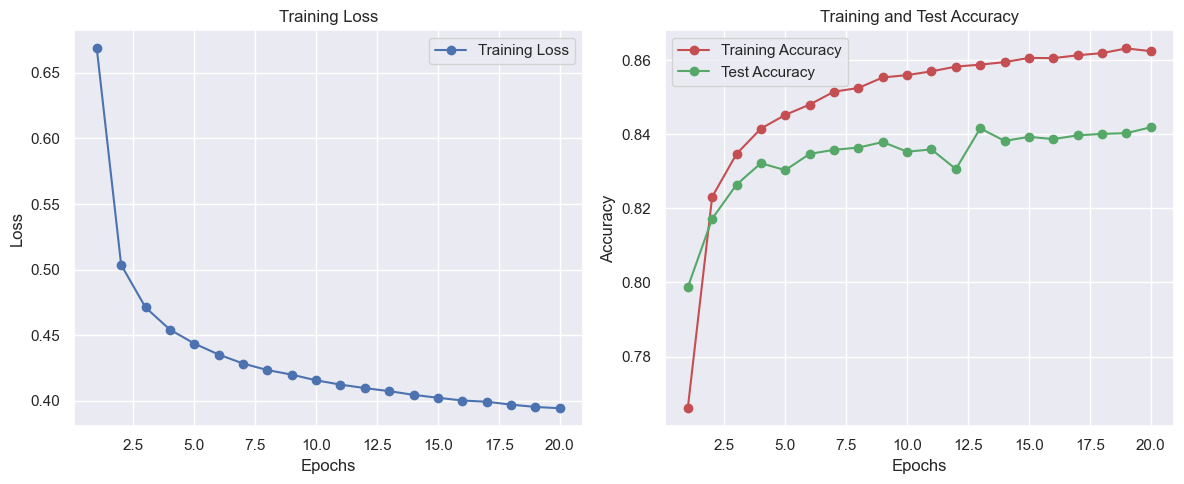

In [42]:
model1.plot_history()

### Model 2: One hidden layers [256] ReLU

In [17]:
model2 = MLP(activation_function=relu(), num_hidden_layers=1, units=[256])
model2.fit(train_loader, test_loader, 0.01, 20)

Epoch 1/20, Loss: 0.6213, Train Accuracy: 0.7820, Test Accuracy: 0.8237
Epoch 2/20, Loss: 0.4518, Train Accuracy: 0.8407, Test Accuracy: 0.8388
Epoch 3/20, Loss: 0.4121, Train Accuracy: 0.8551, Test Accuracy: 0.8455
Epoch 4/20, Loss: 0.3870, Train Accuracy: 0.8632, Test Accuracy: 0.8501
Epoch 5/20, Loss: 0.3703, Train Accuracy: 0.8686, Test Accuracy: 0.8538
Epoch 6/20, Loss: 0.3569, Train Accuracy: 0.8722, Test Accuracy: 0.8538
Epoch 7/20, Loss: 0.3460, Train Accuracy: 0.8755, Test Accuracy: 0.8562
Epoch 8/20, Loss: 0.3355, Train Accuracy: 0.8793, Test Accuracy: 0.8596
Epoch 9/20, Loss: 0.3267, Train Accuracy: 0.8836, Test Accuracy: 0.8594
Epoch 10/20, Loss: 0.3185, Train Accuracy: 0.8863, Test Accuracy: 0.8650
Epoch 11/20, Loss: 0.3120, Train Accuracy: 0.8891, Test Accuracy: 0.8657
Epoch 12/20, Loss: 0.3051, Train Accuracy: 0.8905, Test Accuracy: 0.8671
Epoch 13/20, Loss: 0.2987, Train Accuracy: 0.8930, Test Accuracy: 0.8658
Epoch 14/20, Loss: 0.2926, Train Accuracy: 0.8952, Test Accu

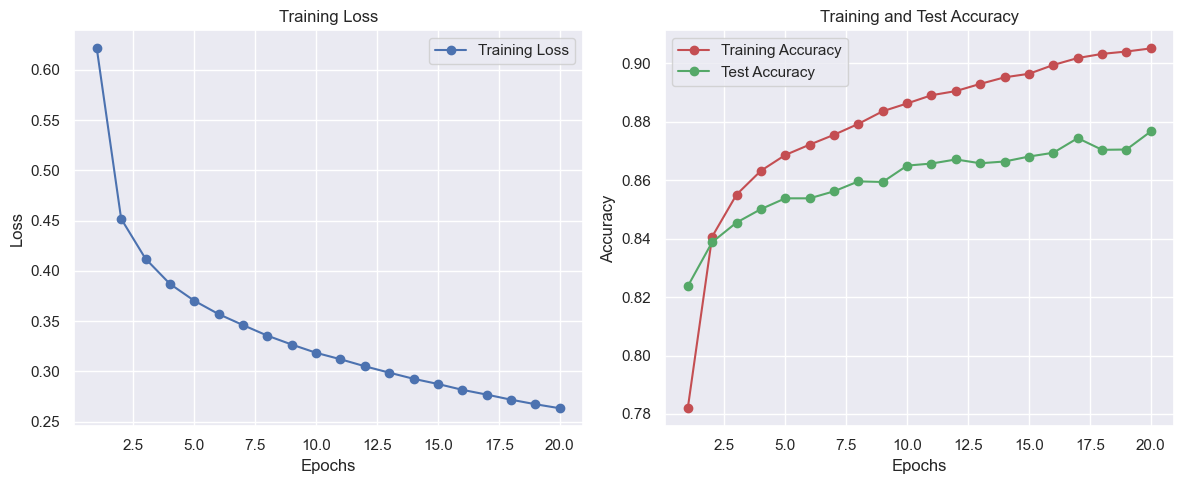

In [18]:
model2.plot_history()

### Model 3: Two hidden layers [256,256] ReLU

In [53]:
model3 = MLP(activation_function=relu(), num_hidden_layers=2, units=[256,256])
model3.fit(train_loader, test_loader, 0.01, 20)

Epoch 1/20, Loss: 0.6046, Train Accuracy: 0.7906, Test Accuracy: 0.8158
Epoch 2/20, Loss: 0.4313, Train Accuracy: 0.8470, Test Accuracy: 0.8425
Epoch 3/20, Loss: 0.3878, Train Accuracy: 0.8611, Test Accuracy: 0.8496
Epoch 4/20, Loss: 0.3621, Train Accuracy: 0.8691, Test Accuracy: 0.8537
Epoch 5/20, Loss: 0.3428, Train Accuracy: 0.8766, Test Accuracy: 0.8594
Epoch 6/20, Loss: 0.3274, Train Accuracy: 0.8817, Test Accuracy: 0.8644
Epoch 7/20, Loss: 0.3147, Train Accuracy: 0.8859, Test Accuracy: 0.8591
Epoch 8/20, Loss: 0.3040, Train Accuracy: 0.8900, Test Accuracy: 0.8648
Epoch 9/20, Loss: 0.2927, Train Accuracy: 0.8935, Test Accuracy: 0.8705
Epoch 10/20, Loss: 0.2835, Train Accuracy: 0.8983, Test Accuracy: 0.8675
Epoch 11/20, Loss: 0.2758, Train Accuracy: 0.9005, Test Accuracy: 0.8733
Epoch 12/20, Loss: 0.2676, Train Accuracy: 0.9032, Test Accuracy: 0.8751
Epoch 13/20, Loss: 0.2602, Train Accuracy: 0.9062, Test Accuracy: 0.8706
Epoch 14/20, Loss: 0.2537, Train Accuracy: 0.9088, Test Accu

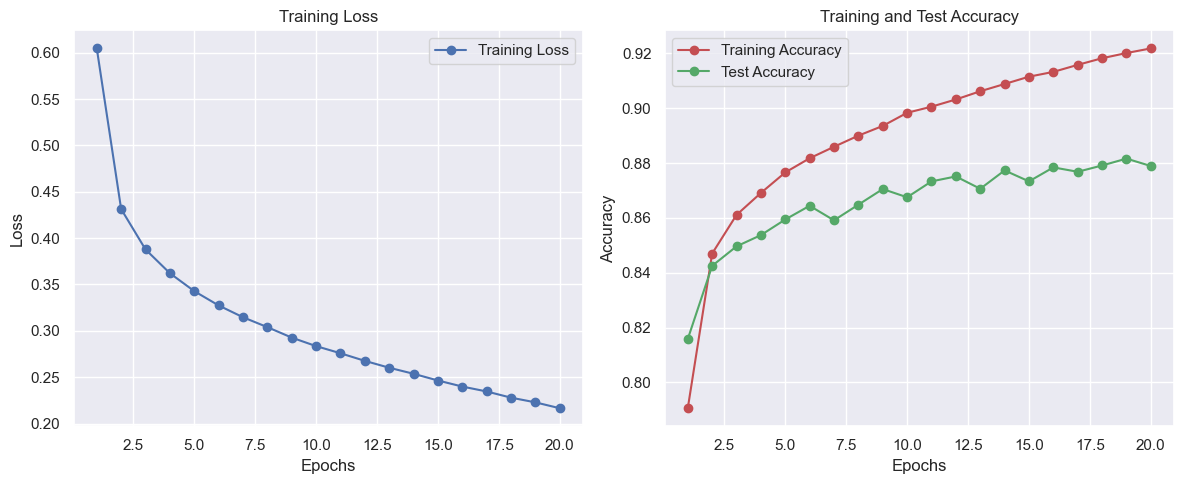

In [55]:
model3.plot_history()

## 3.2: tanh and Leaky-ReLU comparison

### 3.2.1: Creating new models

In [28]:
model_tanh = MLP(activation_function=tanh(), num_hidden_layers=2, units=[256,256])
model_tanh.fit(train_loader, test_loader, 0.01, 20)

Epoch 1/20, Loss: 0.6289, Train Accuracy: 0.7859, Test Accuracy: 0.8188
Epoch 2/20, Loss: 0.4468, Train Accuracy: 0.8430, Test Accuracy: 0.8370
Epoch 3/20, Loss: 0.4034, Train Accuracy: 0.8565, Test Accuracy: 0.8461
Epoch 4/20, Loss: 0.3772, Train Accuracy: 0.8660, Test Accuracy: 0.8513
Epoch 5/20, Loss: 0.3584, Train Accuracy: 0.8722, Test Accuracy: 0.8554
Epoch 6/20, Loss: 0.3436, Train Accuracy: 0.8777, Test Accuracy: 0.8606
Epoch 7/20, Loss: 0.3312, Train Accuracy: 0.8821, Test Accuracy: 0.8602
Epoch 8/20, Loss: 0.3198, Train Accuracy: 0.8858, Test Accuracy: 0.8592
Epoch 9/20, Loss: 0.3099, Train Accuracy: 0.8889, Test Accuracy: 0.8661
Epoch 10/20, Loss: 0.3018, Train Accuracy: 0.8924, Test Accuracy: 0.8689
Epoch 11/20, Loss: 0.2934, Train Accuracy: 0.8948, Test Accuracy: 0.8702
Epoch 12/20, Loss: 0.2852, Train Accuracy: 0.8984, Test Accuracy: 0.8708
Epoch 13/20, Loss: 0.2790, Train Accuracy: 0.8999, Test Accuracy: 0.8701
Epoch 14/20, Loss: 0.2717, Train Accuracy: 0.9032, Test Accu

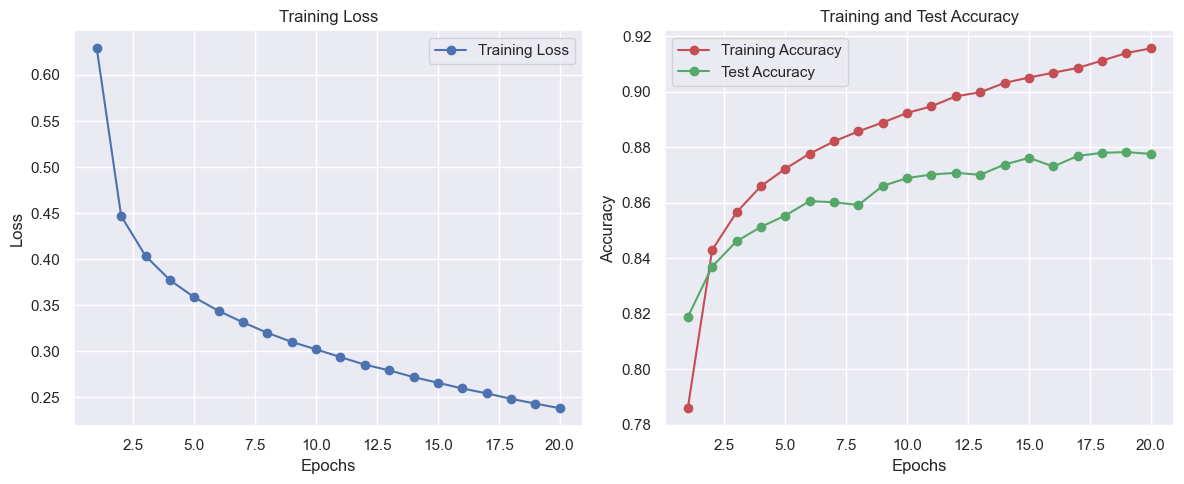

In [46]:
model_tanh.plot_history()

In [30]:
model_leakyrelu = MLP(activation_function=leakyRelu(gamma=0.01), num_hidden_layers=2, units=[256,256])
model_leakyrelu.fit(train_loader, test_loader, 0.01, 20)

Epoch 1/20, Loss: 0.6025, Train Accuracy: 0.7881, Test Accuracy: 0.8275
Epoch 2/20, Loss: 0.4320, Train Accuracy: 0.8439, Test Accuracy: 0.8417
Epoch 3/20, Loss: 0.3890, Train Accuracy: 0.8604, Test Accuracy: 0.8511
Epoch 4/20, Loss: 0.3625, Train Accuracy: 0.8691, Test Accuracy: 0.8544
Epoch 5/20, Loss: 0.3437, Train Accuracy: 0.8752, Test Accuracy: 0.8612
Epoch 6/20, Loss: 0.3285, Train Accuracy: 0.8807, Test Accuracy: 0.8621
Epoch 7/20, Loss: 0.3160, Train Accuracy: 0.8862, Test Accuracy: 0.8667
Epoch 8/20, Loss: 0.3057, Train Accuracy: 0.8900, Test Accuracy: 0.8643
Epoch 9/20, Loss: 0.2952, Train Accuracy: 0.8929, Test Accuracy: 0.8673
Epoch 10/20, Loss: 0.2860, Train Accuracy: 0.8973, Test Accuracy: 0.8660
Epoch 11/20, Loss: 0.2776, Train Accuracy: 0.8999, Test Accuracy: 0.8687
Epoch 12/20, Loss: 0.2697, Train Accuracy: 0.9009, Test Accuracy: 0.8741
Epoch 13/20, Loss: 0.2629, Train Accuracy: 0.9041, Test Accuracy: 0.8740
Epoch 14/20, Loss: 0.2553, Train Accuracy: 0.9074, Test Accu

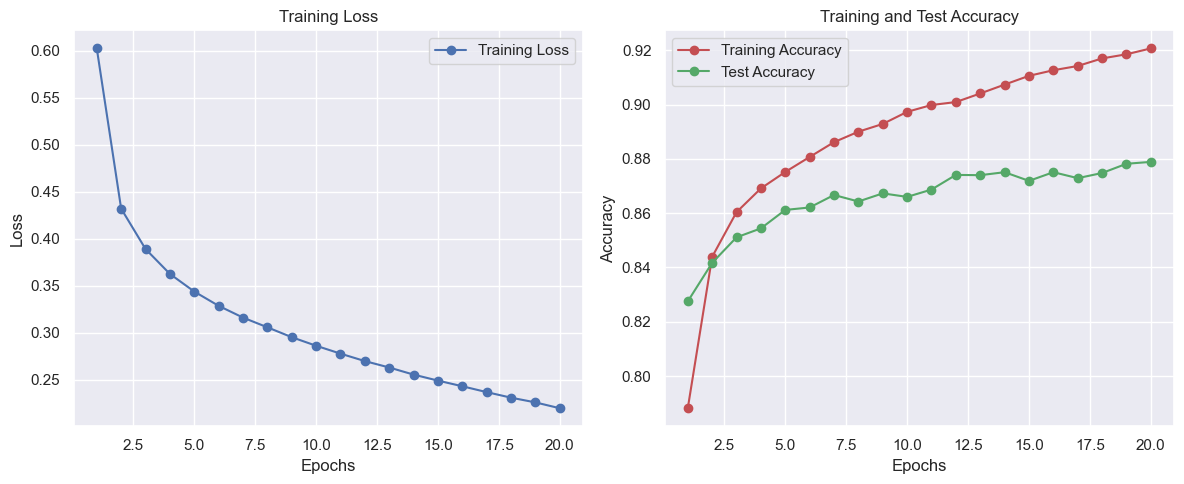

Model saved to saved_models/model_leakyrelu_backup.pkl


In [ ]:
model_leakyrelu.plot_history()


### 3.2.2: Basing of original model3

In [32]:
import copy
model3_tanh = copy.deepcopy(model3)
model3_tanh.activation_function = tanh()
model3_tanh.fit(train_loader, test_loader, 0.01, 20)

Epoch 1/20, Loss: 0.3797, Train Accuracy: 0.8685, Test Accuracy: 0.8608
Epoch 2/20, Loss: 0.2996, Train Accuracy: 0.8942, Test Accuracy: 0.8718
Epoch 3/20, Loss: 0.2776, Train Accuracy: 0.9021, Test Accuracy: 0.8730
Epoch 4/20, Loss: 0.2637, Train Accuracy: 0.9071, Test Accuracy: 0.8732
Epoch 5/20, Loss: 0.2527, Train Accuracy: 0.9111, Test Accuracy: 0.8712
Epoch 6/20, Loss: 0.2443, Train Accuracy: 0.9129, Test Accuracy: 0.8807
Epoch 7/20, Loss: 0.2366, Train Accuracy: 0.9167, Test Accuracy: 0.8799
Epoch 8/20, Loss: 0.2300, Train Accuracy: 0.9183, Test Accuracy: 0.8785
Epoch 9/20, Loss: 0.2247, Train Accuracy: 0.9211, Test Accuracy: 0.8819
Epoch 10/20, Loss: 0.2181, Train Accuracy: 0.9239, Test Accuracy: 0.8786
Epoch 11/20, Loss: 0.2129, Train Accuracy: 0.9254, Test Accuracy: 0.8823
Epoch 12/20, Loss: 0.2077, Train Accuracy: 0.9279, Test Accuracy: 0.8795
Epoch 13/20, Loss: 0.2026, Train Accuracy: 0.9291, Test Accuracy: 0.8827
Epoch 14/20, Loss: 0.1986, Train Accuracy: 0.9317, Test Accu

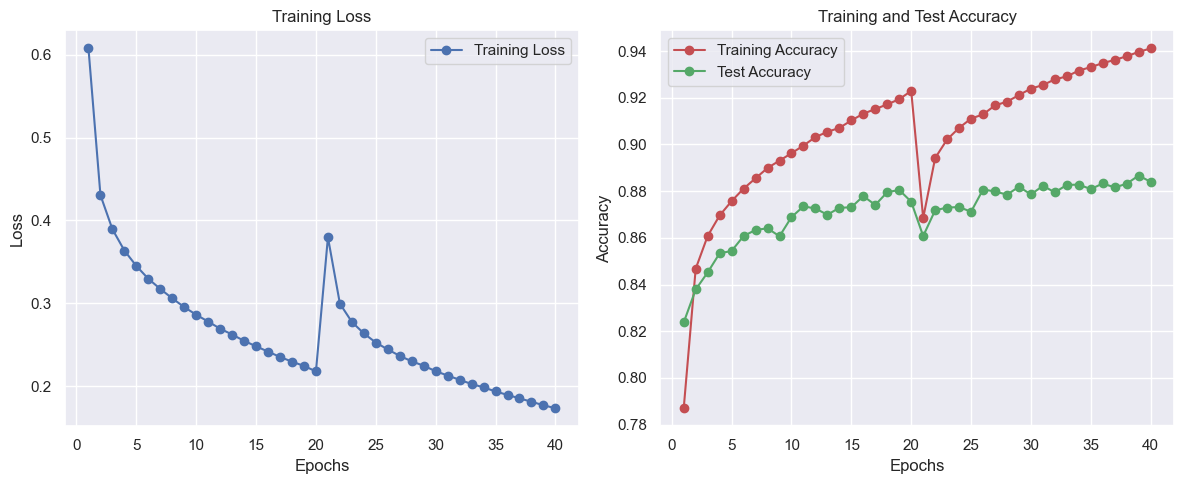

In [49]:
model3_tanh.plot_history()


In [34]:
model3_leakyrelu = copy.deepcopy(model3)
model3_leakyrelu.activation_function = leakyRelu(gamma=0.01)
model3_leakyrelu.fit(train_loader, test_loader, 0.01, 20)

Epoch 1/20, Loss: 0.2139, Train Accuracy: 0.9234, Test Accuracy: 0.8811
Epoch 2/20, Loss: 0.2085, Train Accuracy: 0.9255, Test Accuracy: 0.8788
Epoch 3/20, Loss: 0.2035, Train Accuracy: 0.9275, Test Accuracy: 0.8795
Epoch 4/20, Loss: 0.1986, Train Accuracy: 0.9293, Test Accuracy: 0.8822
Epoch 5/20, Loss: 0.1946, Train Accuracy: 0.9317, Test Accuracy: 0.8851
Epoch 6/20, Loss: 0.1890, Train Accuracy: 0.9327, Test Accuracy: 0.8819
Epoch 7/20, Loss: 0.1847, Train Accuracy: 0.9362, Test Accuracy: 0.8842
Epoch 8/20, Loss: 0.1799, Train Accuracy: 0.9369, Test Accuracy: 0.8839
Epoch 9/20, Loss: 0.1761, Train Accuracy: 0.9375, Test Accuracy: 0.8825
Epoch 10/20, Loss: 0.1718, Train Accuracy: 0.9395, Test Accuracy: 0.8853
Epoch 11/20, Loss: 0.1679, Train Accuracy: 0.9415, Test Accuracy: 0.8814
Epoch 12/20, Loss: 0.1640, Train Accuracy: 0.9434, Test Accuracy: 0.8851
Epoch 13/20, Loss: 0.1605, Train Accuracy: 0.9450, Test Accuracy: 0.8849
Epoch 14/20, Loss: 0.1559, Train Accuracy: 0.9461, Test Accu

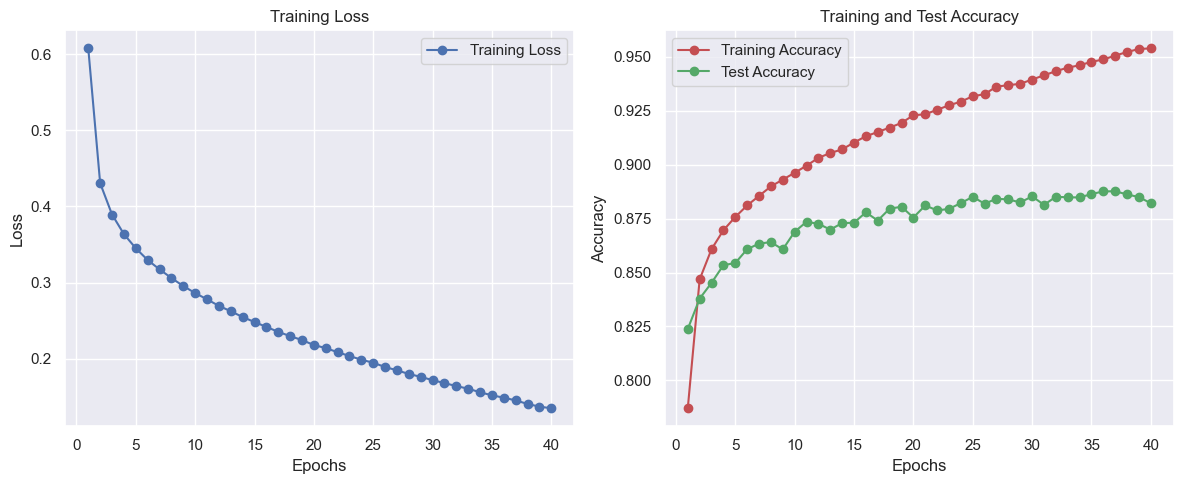

In [52]:
model3_leakyrelu.plot_history()

In [56]:
model3_40epochs = copy.deepcopy(model3)
model3_40epochs.fit(train_loader, test_loader, 0.01, 20)

Epoch 1/20, Loss: 0.2111, Train Accuracy: 0.9249, Test Accuracy: 0.8787
Epoch 2/20, Loss: 0.2067, Train Accuracy: 0.9267, Test Accuracy: 0.8801
Epoch 3/20, Loss: 0.2012, Train Accuracy: 0.9289, Test Accuracy: 0.8804
Epoch 4/20, Loss: 0.1966, Train Accuracy: 0.9309, Test Accuracy: 0.8811
Epoch 5/20, Loss: 0.1916, Train Accuracy: 0.9334, Test Accuracy: 0.8833
Epoch 6/20, Loss: 0.1873, Train Accuracy: 0.9333, Test Accuracy: 0.8823
Epoch 7/20, Loss: 0.1826, Train Accuracy: 0.9358, Test Accuracy: 0.8828
Epoch 8/20, Loss: 0.1788, Train Accuracy: 0.9369, Test Accuracy: 0.8786
Epoch 9/20, Loss: 0.1745, Train Accuracy: 0.9391, Test Accuracy: 0.8785
Epoch 10/20, Loss: 0.1693, Train Accuracy: 0.9405, Test Accuracy: 0.8814
Epoch 11/20, Loss: 0.1668, Train Accuracy: 0.9422, Test Accuracy: 0.8819
Epoch 12/20, Loss: 0.1620, Train Accuracy: 0.9440, Test Accuracy: 0.8846
Epoch 13/20, Loss: 0.1582, Train Accuracy: 0.9464, Test Accuracy: 0.8808
Epoch 14/20, Loss: 0.1541, Train Accuracy: 0.9475, Test Accu

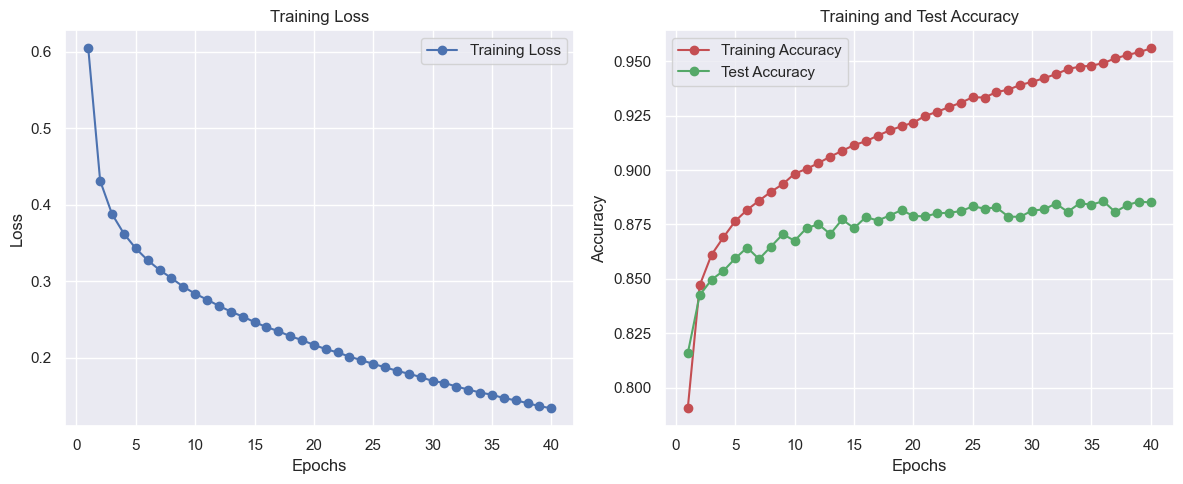

In [58]:
model3_40epochs.plot_history()

## 3.6: CNN Using Pytorch

In [7]:
# Device (use GPU if available but don't change MLP behavior)
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
if device == "cpu":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using device:', device)

Using device: mps


In [10]:
# Create CNN-specific transforms
cnn_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

full_train_cnn = datasets.FashionMNIST(root='./data', train=True, download=True, transform=cnn_transform)
test_dataset_cnn = datasets.FashionMNIST(root='./data', train=False, download=True, transform=cnn_transform)

# split full train set into train and validation sets (80/20)
train_size = int(0.8*len(full_train_cnn))
val_size = len(full_train_cnn) - train_size

# Add generator seed for reproducibility
generator = torch.Generator().manual_seed(42)
train_dataset_cnn, val_dataset_cnn = random_split(full_train_cnn, [train_size, val_size])

# create dataloaders
batch_size = 64
train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=batch_size, shuffle=True)
val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=batch_size, shuffle=False)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=batch_size, shuffle=False)

# sanity check
x_cnn, y_cnn = next(iter(train_loader_cnn))
print((x_cnn.shape, y_cnn.shape)) # expect [64, 1, 28, 28] and [64]

(torch.Size([64, 1, 28, 28]), torch.Size([64]))
